Analysis of the paper "Parametrized Neural Networks for HEP" by Baldi at al. 2016

In [ ]:
import gc
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import optimizers as opt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from typing import List, Tuple, Dict, Union

%matplotlib inline
sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

save_path = "/content/gdrive/My Drive/modelli/PNNs" 

def save_in_drive(fname, content):
  with open(f'{save_path}/{fname}', 'w') as f:
    f.write(content)
    
def load_from_drive(fname):
  with open(f'{save_path}/{fname}', 'r') as f:
    return f.read()

Mounted at /content/gdrive


In [ ]:
# utils
SEED = None

def set_random_seed(seed: int) -> int:
    """Sets the random seed for TensorFlow, numpy, python's random"""
    global SEED
    
    if seed is not None:
        tf.random.set_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        
        SEED = seed
        print(f'Random seed {seed} set.')


def tf_global_norm(tensors: list, **kwargs):
    norms = [tf.norm(x, **kwargs) for x in tensors]
    return tf.sqrt(tf.reduce_sum([norm * norm for norm in norms]))


def free_mem():
    return gc.collect()


def dataset_from_tensors(tensors, batch_size: int, split=0.25, seed=SEED):
    total_size = tensors[-1].shape[0]
    val_size = int(total_size * split)
    train_size = total_size - val_size
    
    dataset = tf.data.Dataset.from_tensor_slices(tensors)
    dataset = dataset.shuffle(buffer_size=1024)

    training_set = dataset.take(train_size)
    training_set = training_set.batch(batch_size)
    
    validation_set = dataset.skip(train_size).take(val_size)
    validation_set = validation_set.batch(batch_size)
    
    free_mem()
    return training_set, validation_set


In [ ]:
set_random_seed(42)

Random seed 42 set.


## Data
---

In [ ]:
# download data
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00347/all_test.csv.gz
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00347/all_train.csv.gz

# unpack
!gzip -d all_test.csv.gz
!gzip -d all_train.csv.gz

--2021-05-08 08:59:10--  http://archive.ics.uci.edu/ml/machine-learning-databases/00347/all_test.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 880352641 (840M) [application/x-httpd-php]
Saving to: ‘all_test.csv.gz’

all_test.csv.gz     100%[===================>] 839.57M   102MB/s    in 8.4s    

2021-05-08 08:59:18 (99.5 MB/s) - ‘all_test.csv.gz’ saved [880352641/880352641]

--2021-05-08 08:59:18--  http://archive.ics.uci.edu/ml/machine-learning-databases/00347/all_train.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1760680846 (1.6G) [application/x-httpd-php]
Saving to: ‘all_train.csv.gz’

all_train.csv.gz    100%[===================>]   1.64

In [ ]:
class Dataset:
    TRAIN_PATH = 'all_train.csv'
    TEST_PATH = 'all_test.csv'

    def __init__(self, x_scaler=None, m_scaler=None):
        self.ds = None
        self.columns = []

        self.x_scaler = x_scaler
        self.m_scaler = m_scaler
        
        self.train_features = None
        self.test_features = None
        self.train_labels = None
        self.test_labels = None
        self.train_mass = None
        self.test_mass = None
        
    def load(self, path: str, mass: Union[np.ndarray, tuple, list] = None, test_size=0.2, 
             fit_scaler=True, seed=SEED):
        """Loads the dataset:
            - selects feature columns,
            - scales the data if a sklearn.Scaler was provided,
            - splits all the data into train and test sets,
            - allows to select which mass to keep.
        """
        if self.ds is not None:
            return

        print('loading...')
        self.ds = pd.read_csv(path, dtype=np.float32, na_filter=False)
        
        # select columns
        columns = dict(feature=self.ds.columns[1:-1],
                       label=self.ds.columns[0], mass=self.ds.columns[-1])
        self.columns = columns
        
        # drop some mass
        if isinstance(mass, (list, tuple)):
            print('selecting mass...')
            self._select_mass(mass)
            free_mem()

        # select series
        self.features = self.ds[columns['feature']]
        self.labels = self.ds[columns['label']]
        self.masses = self.ds[columns['mass']]
        self.unique_mass = sorted(self.ds.mass.unique())
        
        # fit scaler
        if fit_scaler and (self.x_scaler is not None):
            self.x_scaler.fit(self.features.values)
        
        if fit_scaler and (self.m_scaler is not None):
            self.m_scaler.fit(np.reshape(self.unique_mass, newshape=(-1, 1)))
        
        print('dataset loaded.')
        free_mem()
    
    def get(self, mask=None) -> tuple:
        if mask is not None:
            features = self.features[mask].values
            labels = self.labels[mask].values
            mass = self.masses[mask].values
        else:
            features = self.features.values
            labels = self.labels.values
            mass = self.masses.values

        mass = mass.reshape((-1, 1))
        labels = labels.reshape((-1, 1))

        if self.x_scaler is not None:
            features = self.x_scaler.transform(features)
        
        if self.m_scaler is not None:
            mass = self.m_scaler.transform(mass)

        x = dict(x=features, m=mass)
        y = labels
        
        free_mem()
        return x, y
    
    def get_by_mass(self, mass: float) -> dict:
        return self.get(mask=self.ds.mass == mass)
    
    def _select_mass(self, mass):
        """Selects only the given mass from the dataframe"""
        for m in mass:
            # +/- 1 interval is used to account for floating-point inaccuracies
            mask = (self.ds.mass >= m - 1.0) & (self.ds.mass < m + 1.0)

            self.ds.drop(index=self.ds[mask].index, inplace=True)


## Model
---

In [ ]:
#@title
"""Dynamic step-dependent parameters: used as learning rate schedules"""

from tensorflow.keras.optimizers import schedules
from tensorflow.keras.optimizers.schedules import LearningRateSchedule


class DynamicParameter:
    """Interface for learning rate schedule wrappers as dynamic-parameters"""
    def __init__(self):
        self._value = tf.Variable(initial_value=0.0, trainable=False, dtype=tf.float32)
        self.step = tf.Variable(initial_value=0, trainable=False, dtype=tf.int32)

    @property
    def value(self):
        return self._value.value()

    @property
    def variable(self):
        return self._value

    @value.setter
    def value(self, value):
        self._value.assign(value)

    @staticmethod
    def create(value: Union[float, int, LearningRateSchedule], **kwargs):
        """Converts a floating or LearningRateSchedule `value` into a DynamicParameter object"""
        if isinstance(value, (DynamicParameter, ScheduleWrapper)):
            return value

        if isinstance(value, (float, int)):
            return ConstantParameter(value)

        if isinstance(value, LearningRateSchedule):
            return ScheduleWrapper(schedule=value, **kwargs)

        raise ValueError(f'Parameter "value" should be not {type(value)}.')

    def __call__(self, *args, **kwargs):
        return self.value

    def __sub__(self, other):
        self._value.assign_sub(other)

    def __add__(self, other):
        self._value.assign_add(other)

    def serialize(self) -> dict:
        return dict(step=int(self.step.value()))

    def on_step(self):
        self.step.assign_add(delta=1)

    def load(self, config: dict):
        self.step.assign(value=config.get('step', 0))

    def get_config(self) -> dict:
        return {}


class ScheduleWrapper(LearningRateSchedule, DynamicParameter):
    """A wrapper for built-in tf.keras' learning rate schedules"""
    def __init__(self, schedule: LearningRateSchedule, min_value=1e-7, max_value=None):
        super().__init__()
        self.schedule = schedule
        self.min_value = tf.constant(min_value, dtype=tf.float32)

        if isinstance(max_value, (float, int)):
            self.max_value = tf.constant(max_value, dtype=tf.float32)
        else:
            self.max_value = None

        self._value.assign(value=self.schedule.initial_learning_rate)

    def __call__(self, *args, **kwargs):
        self.value = tf.maximum(self.min_value, self.schedule.__call__(self.step))

        if self.max_value:
            self.value = tf.minimum(self.value, self.max_value)

        return self.value

    def get_config(self) -> dict:
        return self.schedule.get_config()


class ConstantParameter(DynamicParameter):
    """A constant learning rate schedule that wraps a constant float learning rate value"""
    def __init__(self, value: float):
        super().__init__()
        self.value = value

    def __call__(self, *args, **kwargs):
        return self.value

    def serialize(self) -> dict:
        return {}


class ExponentialDecay(ScheduleWrapper):
    def __init__(self, initial_value: float, steps: int, rate: float, staircase=False, min_value=0.0, max_value=None):
        super().__init__(schedule=schedules.ExponentialDecay(initial_learning_rate=float(initial_value),
                                                             decay_steps=int(steps), decay_rate=float(rate),
                                                             staircase=bool(staircase)),
                         min_value=min_value, max_value=max_value)


class StepDecay(ScheduleWrapper):
    def __init__(self, initial_value: float, steps: int, rate: float, min_value=1e-7, max_value=None):
        super().__init__(schedule=schedules.ExponentialDecay(initial_learning_rate=float(initial_value),
                                                             decay_steps=int(steps), decay_rate=float(rate),
                                                             staircase=True),
                         min_value=min_value, max_value=max_value)


class LinearDecay(ScheduleWrapper):
    def __init__(self, initial_value: float, end_value: float, steps: int, cycle=False):
        super().__init__(schedule=schedules.PolynomialDecay(initial_learning_rate=float(initial_value),
                                                            decay_steps=int(steps), end_learning_rate=float(end_value),
                                                            power=1.0, cycle=bool(cycle)))


class PolynomialDecay(ScheduleWrapper):
    def __init__(self, initial_value: float, end_value: float, steps: int, power=1.0, cycle=False):
        super().__init__(schedule=schedules.PolynomialDecay(initial_learning_rate=float(initial_value),
                                                            decay_steps=int(steps), end_learning_rate=float(end_value),
                                                            power=power, cycle=bool(cycle)))


In [ ]:
class PNN(Model):
    """A Parametric Neural Network (PNN) model with various way to condition *only* the input layer"""
    
    def __init__(self, input_shapes: dict, weight_decay=0.0, **kwargs):
        name = kwargs.pop('name', 'ParametricNN')
        
        inputs, outputs = self.structure(input_shapes, **kwargs)
        super().__init__(inputs, outputs, name=name)

        self.lr = None
        
        self.weight_decay = tf.constant(weight_decay, dtype=tf.float32)
        self.should_decay_weights = self.weight_decay > 0.0
        
    def compile(self, optimizer_class=opt.Adam, loss='binary_crossentropy', metrics=None, lr=0.001, **kwargs):
        self.lr = DynamicParameter.create(value=lr)
        optimizer = optimizer_class(learning_rate=self.lr, **kwargs)

        super().compile(optimizer, loss, metrics)

    def structure(self, shapes: dict, units=128, num_layers=2, activation='relu', conditioning='concat',
                  dropout=0.0, **kwargs) -> tuple:
        inspect = kwargs.pop('inspect', False)
        apply_dropout = dropout > 0.0
        
        inputs = self.inputs_from_shapes(shapes)
        
        if conditioning == 'paper':
            # input concatenation
            x = concatenate(list(inputs.values()))
            
        elif conditioning == 'concat':
            # input concatenation + linear combination
            x = concatenate(list(inputs.values()))
            x = Dense(units=units, activation='linear', name='linear', **kwargs)(x)

        elif conditioning == 'scaling':
            # linear combination (m) + element-wise multiplication (x)
            x = inputs['x']
            m = inputs['m']

            scaling = Dense(units=x.shape[-1], activation='linear', 
                            name='scaling', **kwargs)(m)
            x = multiply([x, scaling])

        elif conditioning == 'sigmoid':
            # sigmoidal-gating
            x = inputs['x']
            m = inputs['m']

            scaling = Dense(units=x.shape[-1], activation='sigmoid', 
                            name='scaling', **kwargs)(m)
            x = multiply([x, scaling])

        elif conditioning == 'softmax':
            # softmax-gating
            x = inputs['x']
            m = inputs['m']

            scaling = Dense(units=x.shape[-1], activation='softmax', 
                            name='scaling', **kwargs)(m)
            x = multiply([x, scaling])

        elif conditioning == 'affine':
            # apply an affine transformation y = scale(m) * x + bias(m)
            x = inputs['x']
            m = inputs['m']

            scale = Dense(units=x.shape[-1], activation='linear', 
                            name='scale', **kwargs)(m)

            bias =  Dense(units=x.shape[-1], activation='linear', 
                            name='bias', **kwargs)(m)

            x = multiply([x, scale])
            x = add([x, bias])
        else:
            x = inputs['x']

        if conditioning != 'paper' and apply_dropout:
            x = Dropout(rate=dropout)(x)
            
        for _ in range(num_layers):
            x = Dense(units=units, activation=activation, **kwargs)(x)
            
            if apply_dropout:
                x = Dropout(rate=dropout)(x)
        
        outputs = Dense(units=1, activation='sigmoid', **kwargs)(x)

        if inspect:
            return inputs, [outputs, x]

        return inputs, outputs
    
    @tf.function
    def train_step(self, batch):
        if isinstance(batch, tuple) and len(batch) == 1:
            batch = batch[0]
        
        if len(batch) == 3:
            x, labels, sample_weight = batch
        else:
            x, labels = batch
            sample_weight = tf.ones_like(labels)
        
        with tf.GradientTape() as tape:
            classes = self(x, training=True)
            loss = self.compiled_loss(labels, classes, sample_weight=sample_weight)
            
            weight_norm, l2_loss = self.decay_weights()
            total_loss = loss + l2_loss
            
        global_norm, lr = self.apply_gradients(tape, loss)
        self.lr.on_step()

        debug = self.update_metrics(labels, classes, sample_weight=sample_weight)
        debug['loss'] = tf.reduce_mean(loss)
        debug['lr'] = lr
        debug['norm'] = global_norm
        debug['weight-norm'] = weight_norm
        debug['l2-loss'] = l2_loss
        
        return debug
    
    def apply_gradients(self, tape, loss):
        variables = self.trainable_variables

        grads = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(grads, variables))

        return tf_global_norm(grads), self.lr.value
    
    def decay_weights(self) -> tuple:
        weight_norm = tf_global_norm(self.trainable_variables)
            
        if self.should_decay_weights:
            l2_loss = weight_norm * self.weight_decay
        else:
            weight_norm = tf.stop_gradient(weight_norm)
            l2_loss = 0.0
        
        return weight_norm, l2_loss
    
    def update_metrics(self, true, predicted, sample_weight=None) -> dict:
        self.compiled_metrics.update_state(true, predicted, sample_weight=sample_weight)

        return {metric.name: metric.result() for metric in self.metrics}

    @staticmethod
    def inputs_from_shapes(shapes: Dict[str, tuple]) -> Dict[str, Input]:
        return {name: Input(shape=shape, name=name) for name, shape in shapes.items()}


In [ ]:
class AffineConditioning(Layer):
    """Affine transform-based conditioning layer"""

    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.kwargs = kwargs

        self.dense_scale: Dense = None
        self.dense_bias: Dense = None

        self.multiply = Multiply()
        self.add = Add()

    def build(self, input_shape):
        shape, _ = input_shape
        self.dense_scale = Dense(units=shape[-1], activation='linear', **self.kwargs)
        self.dense_bias = Dense(units=shape[-1], activation='linear', **self.kwargs)

    def call(self, inputs, **kwargs):
        assert isinstance(inputs, (list, tuple))
        assert len(inputs) == 2

        # condition input `x` on `z`
        x, z = inputs

        scale = self.dense_scale(z)
        bias = self.dense_bias(z)

        # apply affine transformation, i.e. y = scale(z) * x + bias(z)
        y = self.multiply([x, scale])
        y = self.add([y, bias])
        return y


class AffinePNN(PNN):
    """A PNN that uses Affine conditioning for all layers, not only the Input layer"""
    
    def __init__(self, *args, weight_decay=0.0, mass_weights=None, mass_scaler=None, 
                 mass_intervals: Union[np.ndarray, List[tuple]] = None, **kwargs):
        super().__init__(*args, weight_decay=weight_decay, **kwargs)
        
        # mass weights       
        if isinstance(mass_weights, (list, tuple, np.ndarray)):
            assert len(mass_weights) == len(mass_intervals)
            
            intervals = np.asarray(mass_intervals)
            assert_2d_array(intervals)
            
            self.mass_low = intervals[:, 0]
            self.mass_high = intervals[:, 1]
            
            # scale bins as input mass is scaled
            if mass_scaler is not None:
                self.mass_low = mass_scaler.transform(np.reshape(self.mass_low, newshape=(-1, 1)))
                self.mass_low = tf.squeeze(self.mass_low)
                
                self.mass_high = mass_scaler.transform(np.reshape(self.mass_high, newshape=(-1, 1)))
                self.mass_high = tf.squeeze(self.mass_high)
            
            self.mass_low = tf.cast(self.mass_low, dtype=tf.float32)
            self.mass_high = tf.cast(self.mass_high, dtype=tf.float32)
            
            self.mass_weights = tf.squeeze(mass_weights)
        else:
            self.mass_weights = None
        
    def structure(self, shapes: dict, activation='relu', dropout=0.0, **kwargs) -> tuple:
        inputs = self.inputs_from_shapes(shapes)
        
        apply_dropout = dropout > 0.0
        units = kwargs.pop('units')
        
        x = inputs['x']
        m = inputs['m']
        
        for i, unit in enumerate(units):
            x = Dense(units=unit, activation=activation, **kwargs)(x)
            x = AffineConditioning(name=f'affine-{i}')([x, m])
            
            if apply_dropout:
                x = Dropout(rate=dropout)(x)
        
        out = Dense(units=1, activation='sigmoid', name='classes', **kwargs)(x)
        return inputs, out
    
    @tf.function
    def train_step(self, batch):
        if isinstance(batch, tuple) and len(batch) == 1:
            batch = batch[0]

        if len(batch) == 3:
            x, labels, sample_weight = batch
        else:
            x, labels = batch
        
            sample_weight = self.get_mass_weights(features=x, labels=labels)
        
        with tf.GradientTape() as tape:
            classes = self(x, training=True)
            
            loss = self.compiled_loss(labels, classes, 
                                      sample_weight=sample_weight)
            
            weight_norm, l2_loss = self.decay_weights()
            total_loss = loss + l2_loss
        
        global_norm, lr = self.apply_gradients(tape, total_loss)
        self.lr.on_step()
        
        debug = self.update_metrics(labels, classes, sample_weight=sample_weight)
        debug['total_loss'] = tf.reduce_mean(total_loss)
        debug['loss'] = tf.reduce_mean(loss)
        debug['lr'] = lr
        debug['norm'] = global_norm
        debug['weight-norm'] = weight_norm
        debug['l2_loss'] = l2_loss
    
        return debug
    
    def get_mass_weights(self, features, labels):
        if ('m' in features) and tf.is_tensor(self.mass_weights):
            mass = tf.cast(features['m'], dtype=tf.float32)
            
            # find which mass falls in which bin
            mask = (mass >= self.mass_low) & (mass < self.mass_high)
            bins = tf.argmax(tf.cast(mask, dtype=tf.int32), axis=-1)

            # index by bin and label
            indices = tf.concat([bins[:, None], tf.cast(labels, dtype=tf.int64)], axis=-1)

            # retrieve weights
            mass_weights = tf.gather_nd(self.mass_weights, indices)
            mass_weights = tf.cast(mass_weights, dtype=tf.float32)[:, None]
        else:
            mass_weights = tf.ones_like(labels)
            
        return mass_weights
        

In [ ]:
class MassValidationCallback(tf.keras.callbacks.Callback):
    def __init__(self, data: tuple, batch_size: int, early_stop: Union[bool, int] = False):
        super().__init__()
        
        self.dataset = tf.data.Dataset.from_tensor_slices(data)
        self.dataset = self.dataset.batch(batch_size)
        
        self.auc = tf.keras.metrics.AUC()
        
        # early stopping based on AUC value
        if isinstance(early_stop, int):
            self.should_early_stop = True
            self.patience = early_stop
            
            self.stopped_epoch = 0
            self.best_auc = 0.0
            self.wait = 0
            self.best_weights = None
        else:
            self.should_early_stop = False
    
    def on_train_begin(self, logs=None):
        if not self.should_early_stop:
            return
        
        self.stopped_epoch = 0
        self.best_auc = np.Inf
        self.wait = 0
        self.best_weights = None
    
    def on_epoch_end(self, epoch, logs=None):
        for (x, labels) in self.dataset:
            classes = self.model(x, training=False)
            
            self.auc.update_state(labels, classes)
        
        auc = self.auc.result()
        logs['mass_auc'] = np.round(auc, 4)
        print('\nmass_auc', logs['mass_auc'],'\n')
        
        if not self.should_early_stop:
            return
        
        if np.greater(auc, self.best_auc):
            self.best_auc = auc
            self.wait = 0
            self.best_weights = self.model.get_weights()
            assert self.best_weights is not None
        else:
            self.wait += 1
            
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                
                # restore model weights
                self.model.set_weights(self.best_weights)
    
    def on_train_end(self, logs=None):
        if self.should_early_stop and (self.stopped_epoch > 0):
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


## Reproduce Paper Results
### Training
* As Baldi et al, on a subset of the mass for later interpolation test
* with **Mass validation**, instead
---

In [ ]:
all_mass = [499.99997, 750.0, 1000.0, 1250.0, 1500.0]
train_mass = [499.99997, 1000.0, 1500.0]
val_mass = [750.0, 1250.0]

In [ ]:
# load data
data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load(path=Dataset.TRAIN_PATH, mass=train_mass)

free_mem()

x_train, y_train = data.get()

loading...
selecting mass...
dataset loaded.


In [ ]:
def get_baldi_compiled_model(batch_size=100, val_split=0.25, inspect=False) -> tf.keras.Model:
    # define model architecture as in Baldi et al.
    weight_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=SEED)

    model = PNN(input_shapes=dict(m=(1,), x=(data.features.shape[-1],)), units=500, 
                num_layers=5, conditioning='paper', kernel_initializer=weight_init, inspect=inspect)

    # define optimizer and decaying learning rate schedule
    decay_steps = int(y_train.shape[0] * (1.0 - val_split) / batch_size)

    lr_schedule = StepDecay(0.1, steps=decay_steps, rate=0.89)

    model.compile(optimizer_class=opt.SGD, momentum=0.5,
                  metrics=['binary_accuracy', metrics.AUC()], lr=lr_schedule)
    return model

In [ ]:
model = get_baldi_compiled_model()
model.summary()

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x (InputLayer)                  [(None, 27)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 28)           0           m[0][0]                          
                                                                 x[0][0]                          
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 500)          14500       concatenate_1[0][0]   

In [ ]:
# load mass-validation data
val_data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
val_data.load(path=Dataset.TRAIN_PATH, mass=val_mass)

free_mem()
x_val, y_val = val_data.get()

loading...
selecting mass...
dataset loaded.


In [ ]:
# training without mass validation

h = model.fit(x=x_train, y=y_train, batch_size=batch_size,
              validation_split=val_split, epochs=10)  # the authors train for 200 epochs

Epoch 1/10
31489/31489 [==============================] - 224s 7ms/step - loss: 0.3878 - binary_accuracy: 0.7972 - auc_1: 0.8899 - lr: 0.1000 - norm: 0.5512 - weight-norm: 103.9888 - l2-loss: 0.0000e+00 - val_loss: 0.3860 - val_binary_accuracy: 0.8131 - val_auc_1: 0.9066
Epoch 2/10
31489/31489 [==============================] - 218s 7ms/step - loss: 0.3628 - binary_accuracy: 0.8254 - auc_1: 0.9137 - lr: 0.0890 - norm: 0.4820 - weight-norm: 105.0794 - l2-loss: 0.0000e+00 - val_loss: 0.3627 - val_binary_accuracy: 0.8248 - val_auc_1: 0.9145
Epoch 3/10
31489/31489 [==============================] - 216s 7ms/step - loss: 0.3562 - binary_accuracy: 0.8303 - auc_1: 0.9177 - lr: 0.0792 - norm: 0.4698 - weight-norm: 105.8300 - l2-loss: 0.0000e+00 - val_loss: 0.3672 - val_binary_accuracy: 0.8232 - val_auc_1: 0.9134
Epoch 4/10
31489/31489 [==============================] - 213s 7ms/step - loss: 0.3525 - binary_accuracy: 0.8330 - auc_1: 0.9197 - lr: 0.0705 - norm: 0.4670 - weight-norm: 106.4003 - l

In [ ]:
# training with "mass validation"

model_mv = get_baldi_compiled_model()

callback = MassValidationCallback(data=(x_val, y_val), 
                                  batch_size=batch_size, early_stop=10)

h = model_mv.fit(x=x_train, y=y_train, batch_size=batch_size,
                 validation_split=val_split, callbacks=[callback],
                 epochs=15)  

Epoch 1/15
31489/31489 [==============================] - 212s 7ms/step - loss: 0.3872 - binary_accuracy: 0.7980 - auc_4: 0.8903 - lr: 0.1000 - norm: 0.5579 - weight-norm: 104.0088 - l2-loss: 0.0000e+00 - val_loss: 0.3794 - val_binary_accuracy: 0.8173 - val_auc_4: 0.9083

mass_auc 0.9387 

Epoch 2/15
31489/31489 [==============================] - 219s 7ms/step - loss: 0.3625 - binary_accuracy: 0.8255 - auc_4: 0.9139 - lr: 0.0890 - norm: 0.4854 - weight-norm: 105.1064 - l2-loss: 0.0000e+00 - val_loss: 0.3620 - val_binary_accuracy: 0.8256 - val_auc_4: 0.9149

mass_auc 0.9345 

Epoch 3/15
31489/31489 [==============================] - 213s 7ms/step - loss: 0.3560 - binary_accuracy: 0.8306 - auc_4: 0.9178 - lr: 0.0792 - norm: 0.4746 - weight-norm: 105.8555 - l2-loss: 0.0000e+00 - val_loss: 0.3650 - val_binary_accuracy: 0.8249 - val_auc_4: 0.9147

mass_auc 0.9332 

Epoch 4/15
31489/31489 [==============================] - 214s 7ms/step - loss: 0.3523 - binary_accuracy: 0.8331 - auc_4: 0.919

TypeError: ignored

In [ ]:
# train affine-model with mass-validation
affine_model = AffinePNN(input_shapes=dict(m=(1,), x=(data.features.shape[-1],)), 
                         units=[500, 350, 200, 100], 
                         kernel_initializer='orthogonal', bias_initializer='glorot_uniform')

decay_steps = int(y_train.shape[0] * (1.0 - val_split) / batch_size)

lr_schedule = StepDecay(1e-3, steps=decay_steps, rate=0.75)

affine_model.compile(optimizer_class=opt.Adam,
                metrics=['binary_accuracy', metrics.AUC()], lr=lr_schedule)
affine_model.summary()

callback = MassValidationCallback(data=(x_val, y_val), 
                                  batch_size=batch_size, early_stop=10)

_ = affine_model.fit(x=x_train, y=y_train, batch_size=batch_size,
                     validation_split=val_split, callbacks=[callback],
                     epochs=15)  # overfits at epoch 4

* Saving & loading

In [ ]:
# save
model.save_weights(f'{save_path}/baldi_3_mass/weights')
model_mv.save_weights(f'{save_path}/baldi_mass_val/weights')
affine_model.save_weights(f'{save_path}/affine_3_mass/weights')

In [ ]:
# load
model.load_weights(f'{save_path}/baldi_3_mass/weights')
model_mv.load_weights(f'{save_path}/baldi_mass_val/weights')
affine_model.load_weights(f'{save_path}/affine_3_mass/weights')

## Analysis
* Compare AUC metric towards various mass [`auc_vs_mass`] with error bars.
* Compare AUC vs mass when some (or all) features from $x$ are dropped [`auc_vs_mass_no_features`].
* Generalization capability by interpolation between unknown (not trained on) mass.
---

In [ ]:
test_data = Dataset(x_scaler=data.x_scaler, m_scaler=data.m_scaler)
test_data.load(path=Dataset.TEST_PATH, fit_scaler=False)

test_mass = test_data.unique_mass

loading...
dataset loaded.


In [ ]:
def check_underflow(metric, control_metric) -> float:
    if metric == 0.0 and control_metric >= 0.9:
        return 1.0  # underflow occurred (metric would be wrongly 0.0)
    
    return metric  # no uderflow


def split_dataset(dataset: Dataset, data: tuple, num_folds=10, seed=SEED):
    """Splits a given Dataframe into k disjoint folds"""
    fold_size = data[1].shape[0] // num_folds
    folds = []
    
    # first, construct a dataframe from data, where `data = dict(x, m), y`
    df = pd.concat([
        pd.DataFrame(data[0]['x'], columns=dataset.columns['feature']),
        pd.DataFrame(data[0]['m'], columns=['mass']),
        pd.DataFrame(data[1], columns=['label'])
    ], axis=1)
    
    for _ in range(num_folds - 1):
        fold = df.sample(fold_size, random_state=seed)
        folds.append(fold)
        
        df.drop(fold.index, inplace=True)
    
    folds.append(df)
    
    # make each `fold` be structured like `data`, i.e. fold = tuple(dict(x, m), y)
    for i, fold in enumerate(folds):       
        fold_x = dict(x=fold[dataset.columns['feature']].values, 
                      m=fold['mass'].values)
        fold_y = fold['label'].values
    
        folds[i] = (fold_x, fold_y)
    
    return folds

In [ ]:
def auc_with_error(model, dataset, auc_index: int, mass: Union[np.ndarray, list, tuple], 
                   figsize=(26, 20), num_folds=10, verbose=0):
    plt.figure(figsize=figsize)

    auc = {fold: [] for fold in range(num_folds)}
    
    for m in mass:
        x, y = dataset.get_by_mass(m)
        
        folds = split_dataset(dataset, data=(x, y), num_folds=num_folds)
        
        for i, fold in enumerate(folds):
            score = model.evaluate(x=fold[0], y=fold[1], batch_size=128, verbose=verbose)

            auc_score = round(score[auc_index], 4)
            auc[i].append(check_underflow(auc_score, score[1]))
        
        print(f'Mass: {m}')
    
    # compute average AUC (over folds)
    avg_auc = []
    
    for i, _ in enumerate(mass):
        score = 0.0
        
        for fold in range(num_folds):
            score += auc[fold][i]
        
        avg_auc.append(round(score / num_folds, 4))
    
    plt.title(f'AUC vs Mass')
    plt.ylabel('AUC')
    plt.xlabel('Mass')
    
    plt.plot(mass, avg_auc, label='avg')
    plt.scatter(mass, avg_auc, s=50, color='b')
    
    for i in range(num_folds):
        plt.scatter(mass, auc[i], s=30, color='r')
    
    plt.show()
    return auc


* Measure AUC for various mass values:
If network was trained on a subset of available mass, then this also test its capability to interpolate.

Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0


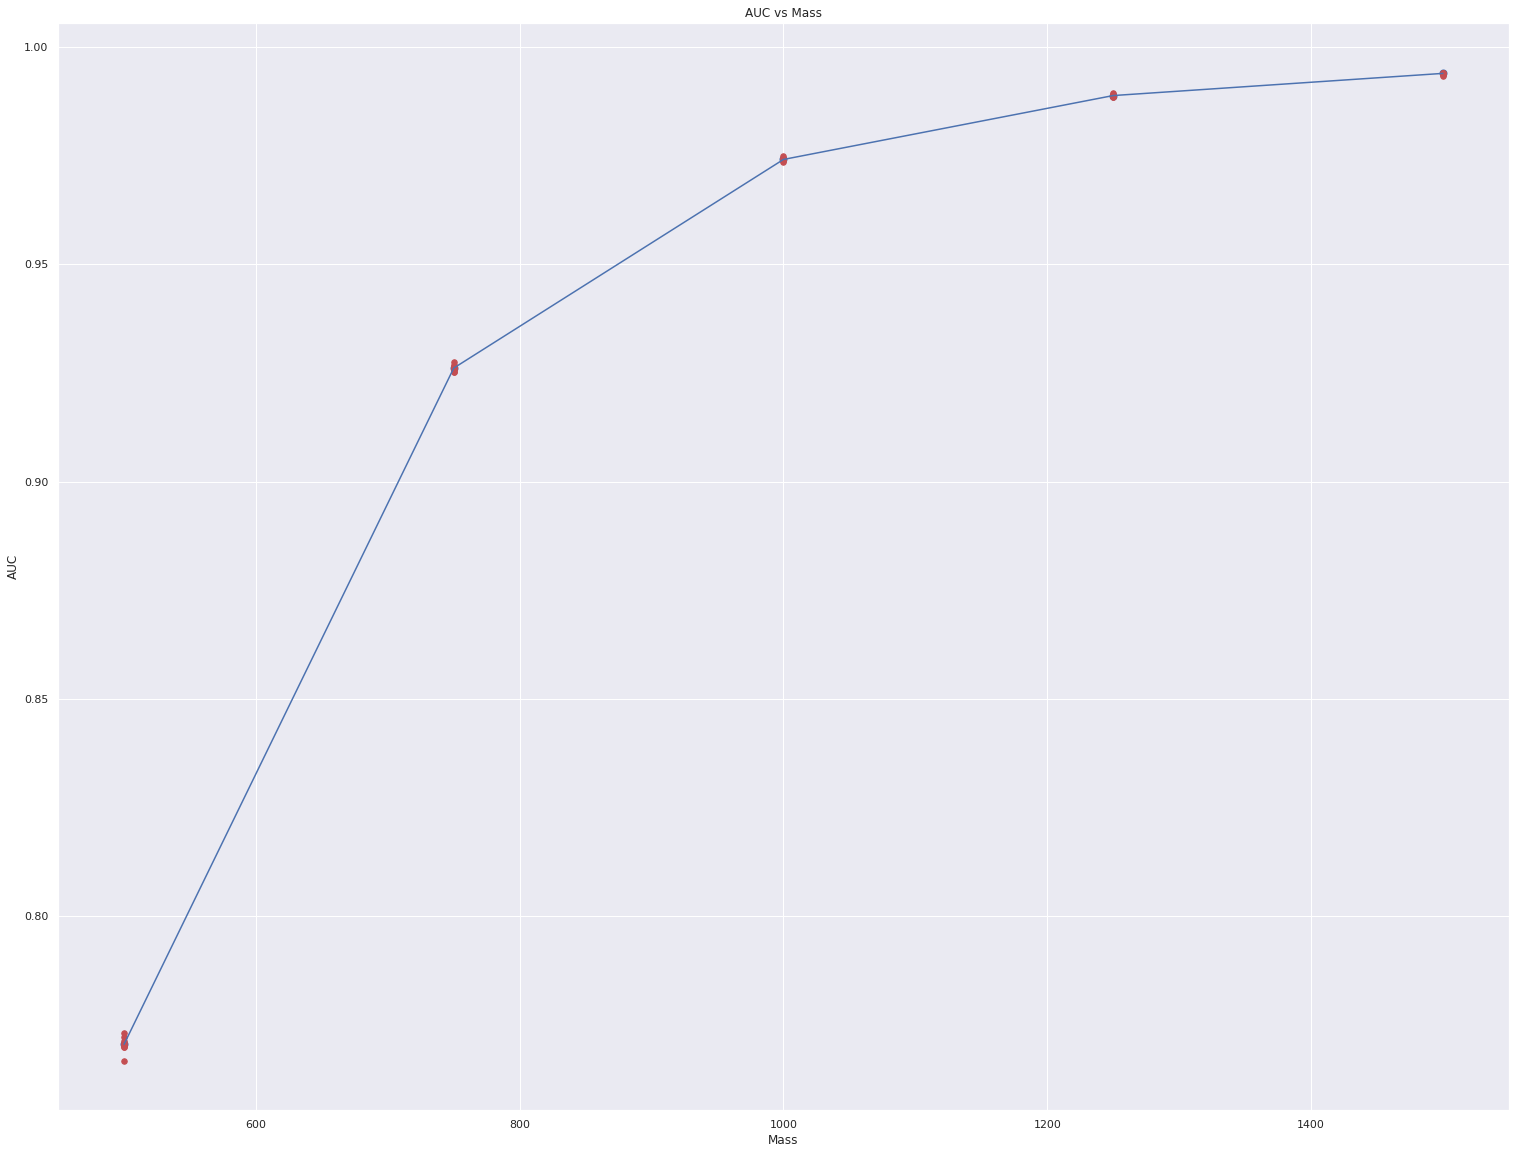

{0: [0.7667, 0.9252, 0.9748, 0.9895, 0.9939],
 1: [0.7712, 0.9252, 0.9741, 0.9884, 0.9938],
 2: [0.7731, 0.9265, 0.9743, 0.9887, 0.9936],
 3: [0.7721, 0.9257, 0.9738, 0.9892, 0.9941],
 4: [0.7698, 0.9258, 0.9739, 0.9887, 0.9939],
 5: [0.7708, 0.9261, 0.9742, 0.989, 0.9938],
 6: [0.7704, 0.9264, 0.9745, 0.9885, 0.9941],
 7: [0.7698, 0.9262, 0.9739, 0.9888, 0.9941],
 8: [0.7703, 0.9274, 0.9736, 0.9888, 0.9934],
 9: [0.7706, 0.9269, 0.9742, 0.9888, 0.994]}

In [ ]:
auc_with_error(model, test_data, auc_index=2, mass=test_mass, num_folds=10, verbose=0)

Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0


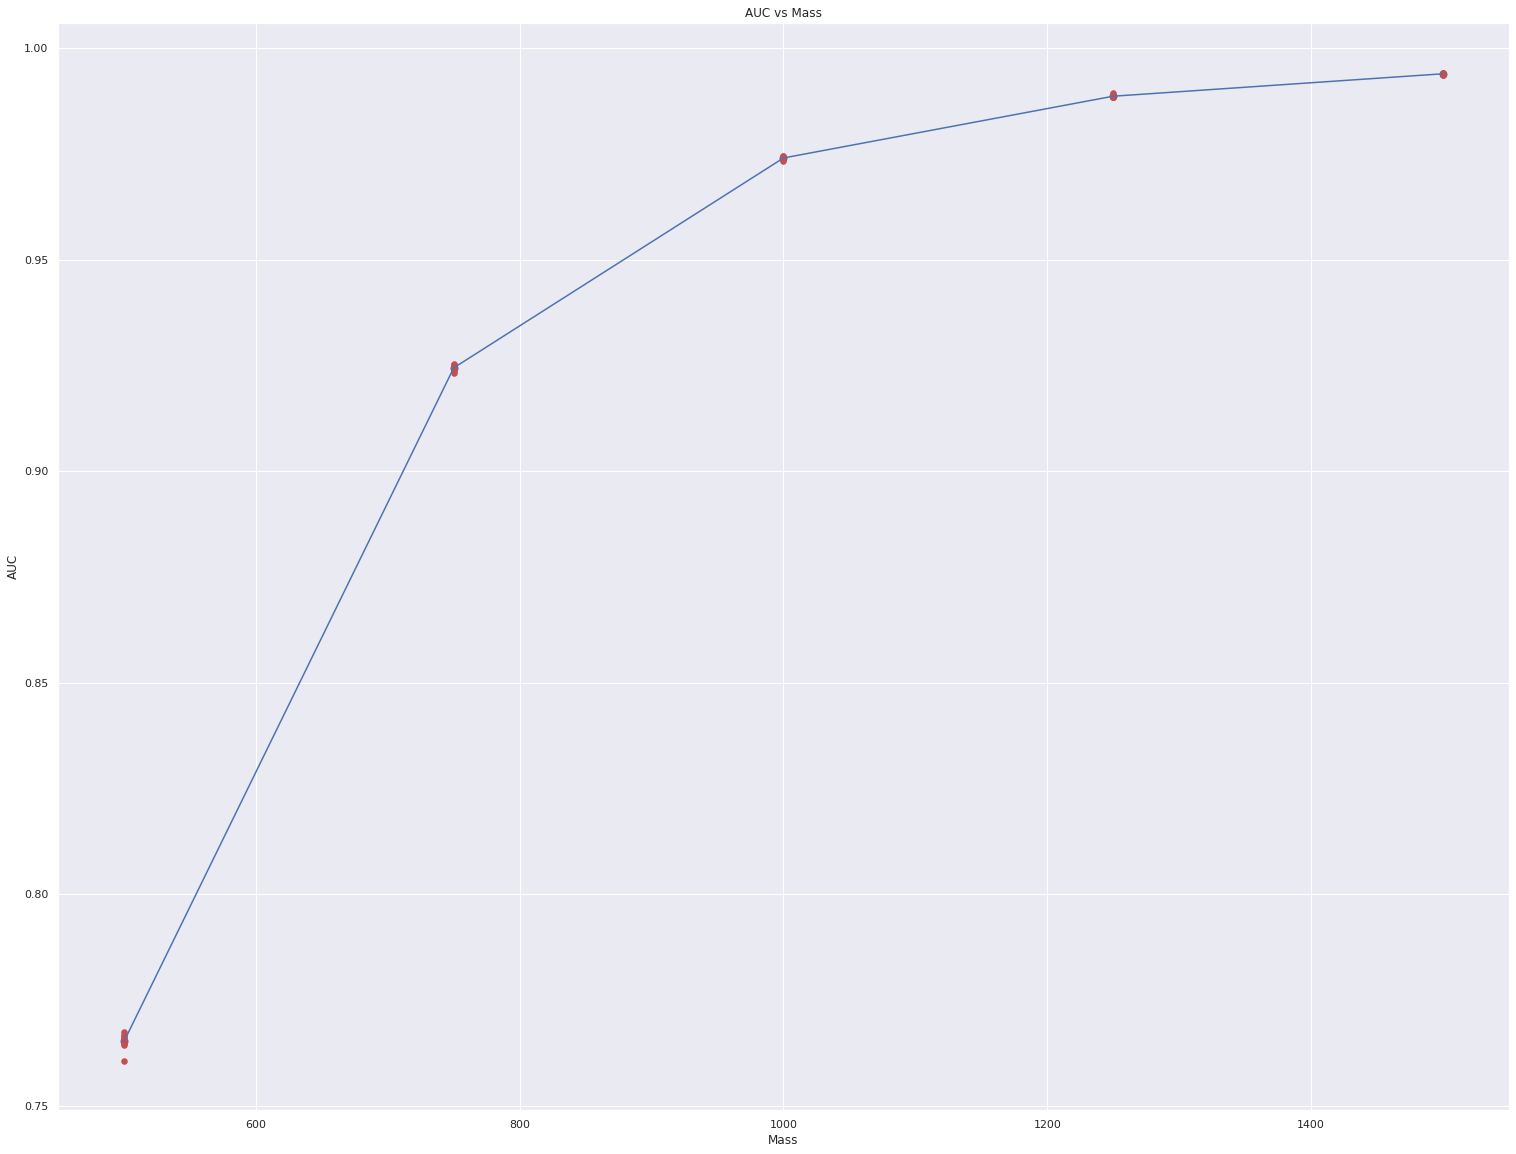

{0: [0.7606, 0.9232, 0.9745, 0.9893, 0.994],
 1: [0.7654, 0.9238, 0.974, 0.9883, 0.9939],
 2: [0.7675, 0.925, 0.9741, 0.9885, 0.9937],
 3: [0.7666, 0.9238, 0.9737, 0.9887, 0.9939],
 4: [0.7648, 0.9244, 0.9737, 0.9884, 0.9939],
 5: [0.7658, 0.9247, 0.9741, 0.9886, 0.9939],
 6: [0.7661, 0.925, 0.9744, 0.9883, 0.9942],
 7: [0.7644, 0.9243, 0.9739, 0.9884, 0.9941],
 8: [0.7664, 0.9252, 0.9734, 0.9885, 0.9936],
 9: [0.7648, 0.9249, 0.974, 0.9886, 0.9938]}

In [ ]:
# affine model
auc_with_error(affine_model, test_data, auc_index=2, mass=test_mass, num_folds=10, verbose=0)

In [ ]:
# auc_with_error(model_mv, test_data, auc_index=2, mass=test_mass, num_folds=10, verbose=0)

* **Sanity check**: control if network is fooled by a single mass value

In [ ]:
def auc_vs_no_mass(model, dataset, auc_index: int, mass: Union[np.ndarray, list, tuple], 
                   fake_mass=[], figsize=(26, 20), verbose=1):
    plt.figure(figsize=figsize)

    # scale mass
    scaled_fake_mass = dataset.m_scaler.transform(np.reshape(fake_mass, newshape=(-1, 1)))
    scaled_fake_mass = np.squeeze(scaled_fake_mass)

    auc = {m: [] for m in scaled_fake_mass}

    for m in mass:
        print(f'Mass: {m}')
        x, y = dataset.get_by_mass(m)
        
        for fake_m in scaled_fake_mass:
            x['m'] = np.ones_like(x['m']) * fake_m
        
            score = model.evaluate(x=x, y=y, batch_size=128, verbose=verbose)
            
            auc_score = round(score[auc_index], 4)
            auc[fake_m].append(check_underflow(auc_score, score[1]))
    
    plt.title(f'AUC vs Mass')
    
    for i, fake_m in enumerate(fake_mass):
        k = scaled_fake_mass[i]

        plt.plot(mass, auc[k], label=f'm-{round(fake_m, 2)}')
        plt.scatter(mass, auc[k], s=50)
        
    plt.legend(loc='best')
    plt.ylabel('AUC')
    plt.xlabel('Mass')
    
    plt.show()
    return auc

Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0


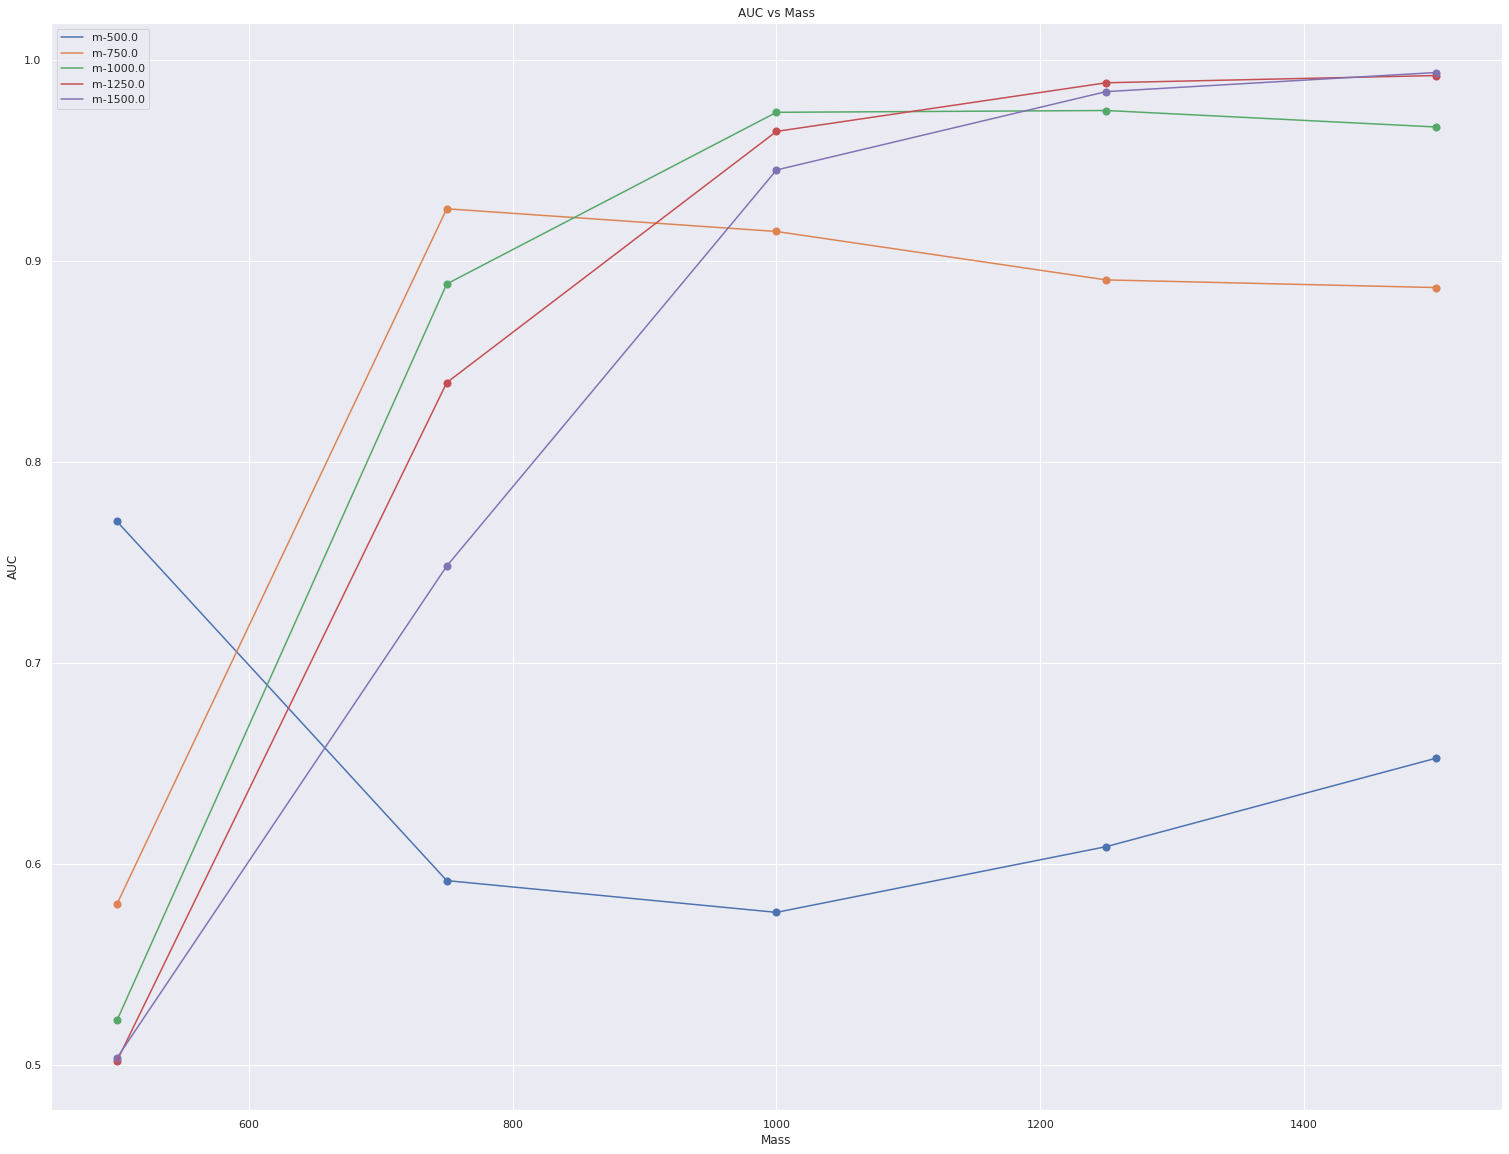

{3.259629011154175e-08: [0.7705, 0.5918, 0.576, 0.6087, 0.6527],
 0.3333333623595536: [0.5802, 0.9261, 0.9148, 0.8907, 0.8869],
 0.666666692122817: [0.5223, 0.8887, 0.9741, 0.975, 0.9668],
 1.0000000218860805: [0.5021, 0.8396, 0.9646, 0.9888, 0.9924],
 1.333333351649344: [0.5036, 0.7483, 0.9454, 0.9844, 0.9939]}

In [ ]:
auc_vs_no_mass(model, test_data, auc_index=2, mass=test_mass, 
               fake_mass=np.linspace(500, 1500, 5), verbose=0)

Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0


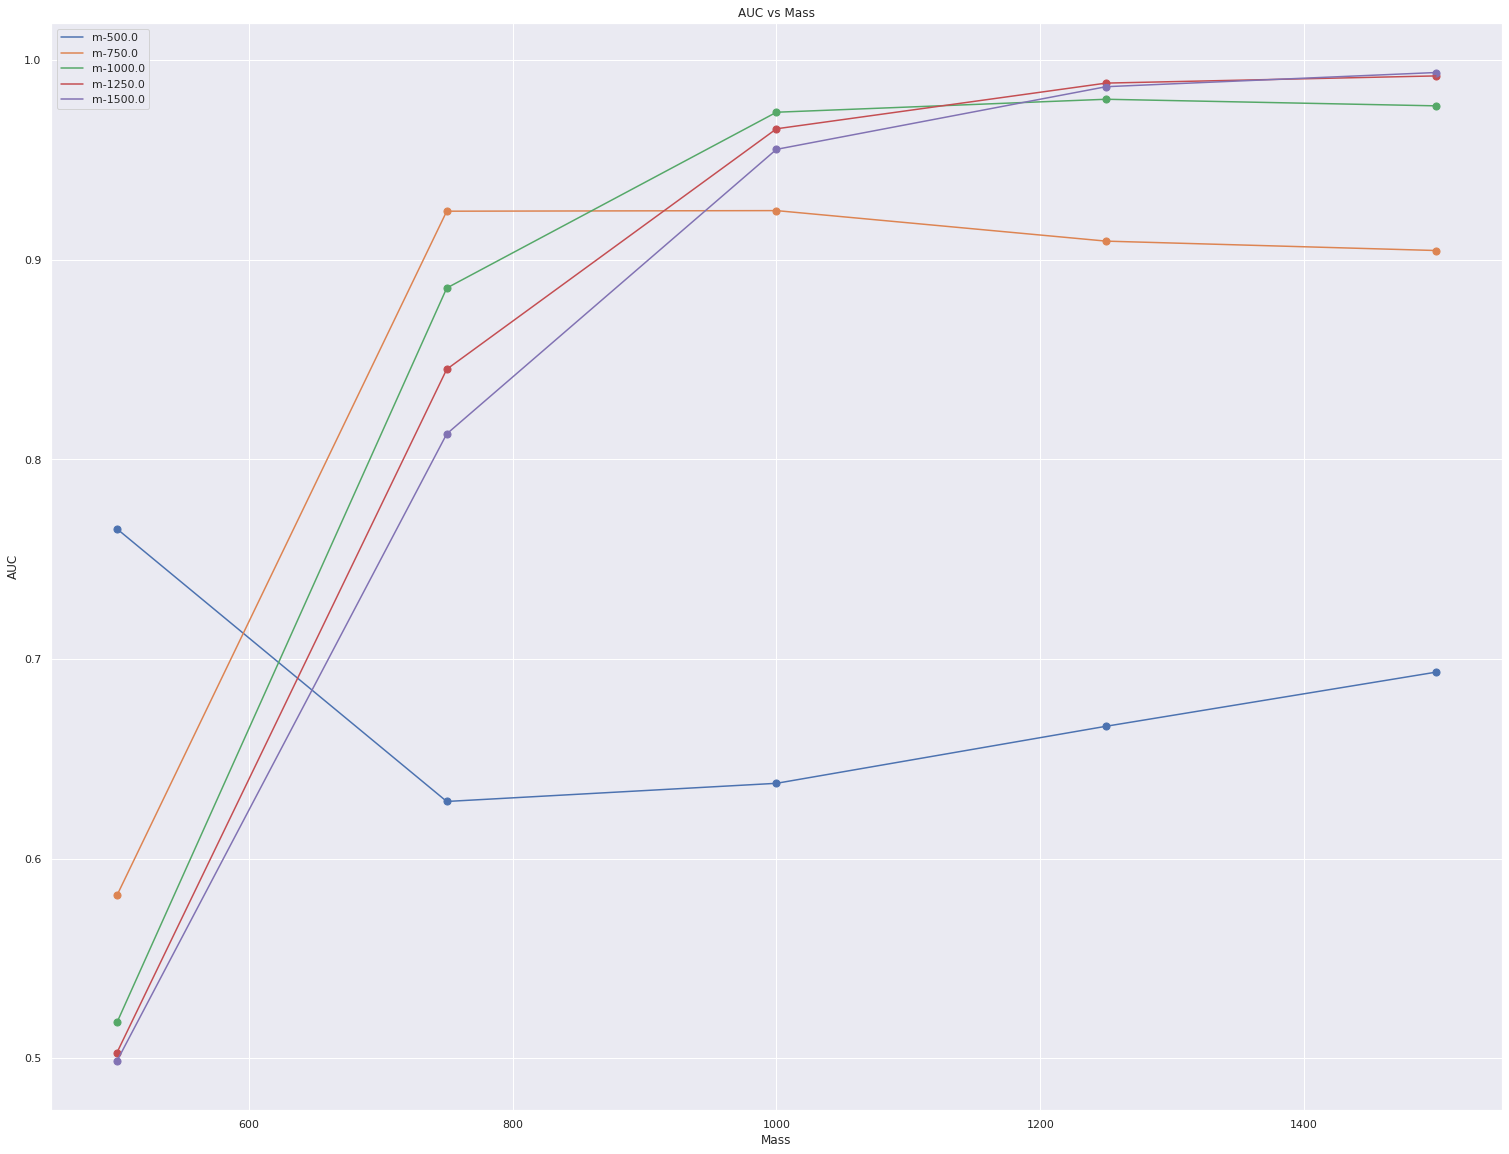

{3.259629011154175e-08: [0.7652, 0.6286, 0.6377, 0.6663, 0.6934],
 0.3333333623595536: [0.5816, 0.9244, 0.9247, 0.9094, 0.9047],
 0.666666692122817: [0.5179, 0.8859, 0.974, 0.9805, 0.9772],
 1.0000000218860805: [0.5028, 0.8452, 0.9657, 0.9886, 0.9922],
 1.333333351649344: [0.4986, 0.8128, 0.9554, 0.9868, 0.9939]}

In [ ]:
# affine model
auc_vs_no_mass(affine_model, test_data, auc_index=2, mass=test_mass, 
               fake_mass=np.linspace(500, 1500, 5), verbose=0)

In [ ]:
# auc_vs_no_mass(model_mv, test_data, auc_index=2, mass=test_mass, const=fake_mass, verbose=0)

* How much the PNN relies on the features `x`?

Set some (or all) of them to zero and compute the AUC w.r.t. the mass.

In [ ]:
def auc_vs_mass_no_features(model, dataset, auc_index: int, mass: Union[np.ndarray, list, tuple], 
                            figsize=(26, 20), features={}, limit=False, verbose=1):
    plt.figure(figsize=figsize)

    auc = {k: [] for k in features.keys()}
    
    for label, indexes in features.items():
        print(f'Features: {label}, {indexes}')
        
        for m in mass:
            x, y = dataset.get_by_mass(m)

            if isinstance(limit, int):
                y = y[:limit]
                x = {k: v[:limit] for k, v in x.items()}

            # mask features
            for i in indexes:
                zero_feature = np.zeros_like(x['x'][:, i])
                x['x'][:, i] = zero_feature
        
            print(f'Mass: {m}')
            score = model.evaluate(x=x, y=y, batch_size=128, verbose=verbose)
            
            auc_score = round(score[auc_index], 4)
            auc[label].append(check_underflow(auc_score, score[1]))
            
    plt.title(f'AUC vs Mass')
    
    for label in features.keys():
        plt.plot(mass, auc[label])
        plt.scatter(mass, auc[label], s=50, label=label)
    
    plt.ylabel('AUC')
    plt.xlabel('Mass')
    
    plt.legend()
    plt.show()
    return auc

In [ ]:
num_features = test_data.features.shape[-1]

features = {
    'all': [],
    'none': np.arange(0, num_features),
}

# add an entry telling to drop only the i-th feature column
for i in range(num_features):
    features[f'no-{i}'] = [i]


Features: all, []
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: none, [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: no-0, [0]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: no-1, [1]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: no-2, [2]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: no-3, [3]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: no-4, [4]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: no-5, [5]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: no-6, [6]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: no-7, [7]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.

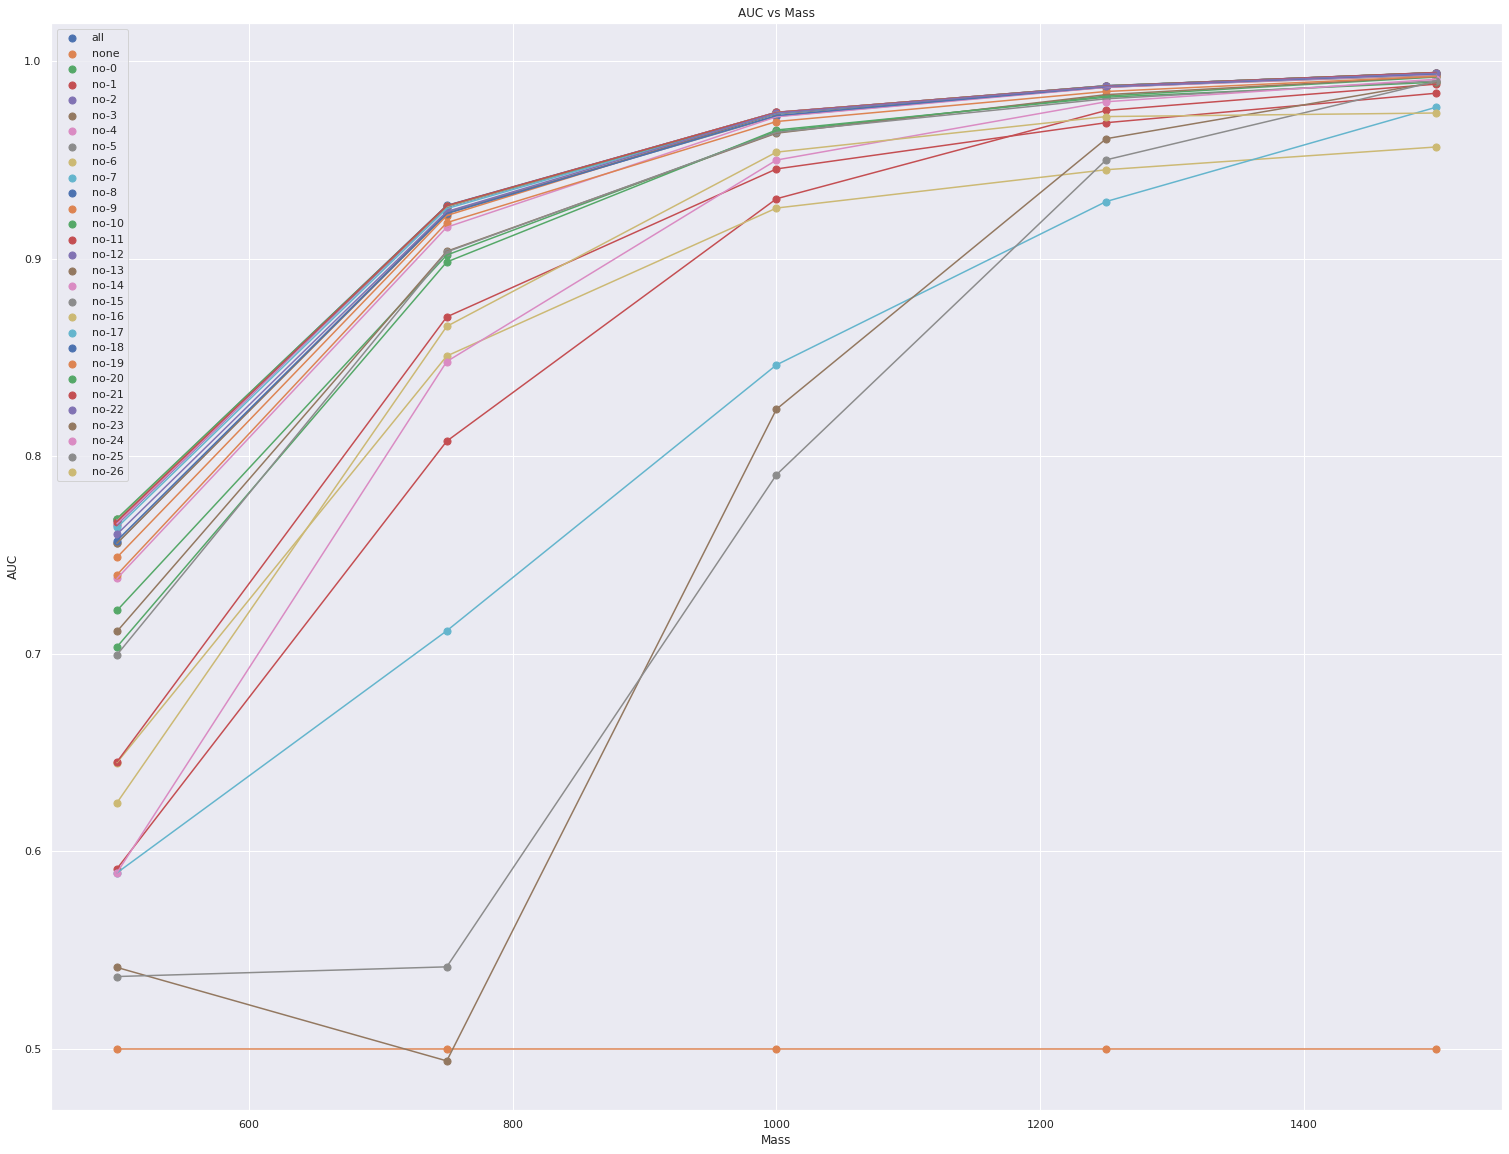

{'all': [0.768, 0.9269, 0.974, 0.9875, 0.9941],
 'no-0': [0.7219, 0.9018, 0.9644, 0.9823, 0.9919],
 'no-1': [0.5912, 0.8076, 0.9303, 0.975, 0.9883],
 'no-10': [0.7035, 0.8983, 0.9651, 0.9817, 0.9893],
 'no-11': [0.6453, 0.8705, 0.9454, 0.9688, 0.9837],
 'no-12': [0.7675, 0.9262, 0.974, 0.9875, 0.9941],
 'no-13': [0.756, 0.9228, 0.9732, 0.9867, 0.9937],
 'no-14': [0.7381, 0.9159, 0.9718, 0.9867, 0.9932],
 'no-15': [0.6995, 0.9034, 0.9639, 0.9809, 0.99],
 'no-16': [0.7681, 0.9264, 0.974, 0.9875, 0.9941],
 'no-17': [0.7639, 0.9253, 0.9735, 0.9875, 0.994],
 'no-18': [0.7573, 0.9229, 0.9724, 0.987, 0.9935],
 'no-19': [0.74, 0.9182, 0.9694, 0.9846, 0.9923],
 'no-2': [0.7653, 0.9265, 0.9741, 0.9874, 0.9941],
 'no-20': [0.7684, 0.9267, 0.9738, 0.9874, 0.9942],
 'no-21': [0.7669, 0.9268, 0.974, 0.9874, 0.9942],
 'no-22': [0.7605, 0.9238, 0.9737, 0.9872, 0.9938],
 'no-23': [0.5412, 0.4939, 0.8238, 0.9607, 0.9893],
 'no-24': [0.5892, 0.8479, 0.9499, 0.9794, 0.9908],
 'no-25': [0.5366, 0.5415, 0.7

In [ ]:
auc_vs_mass_no_features(model, test_data, auc_index=2, mass=test_mass, features=features, 
                        limit=10_000, verbose=0)

Features: all, []
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: none, [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: no-0, [0]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: no-1, [1]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: no-2, [2]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: no-3, [3]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: no-4, [4]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: no-5, [5]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: no-6, [6]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.0
Mass: 1250.0
Mass: 1500.0
Features: no-7, [7]
Mass: 499.9999694824219
Mass: 750.0
Mass: 1000.

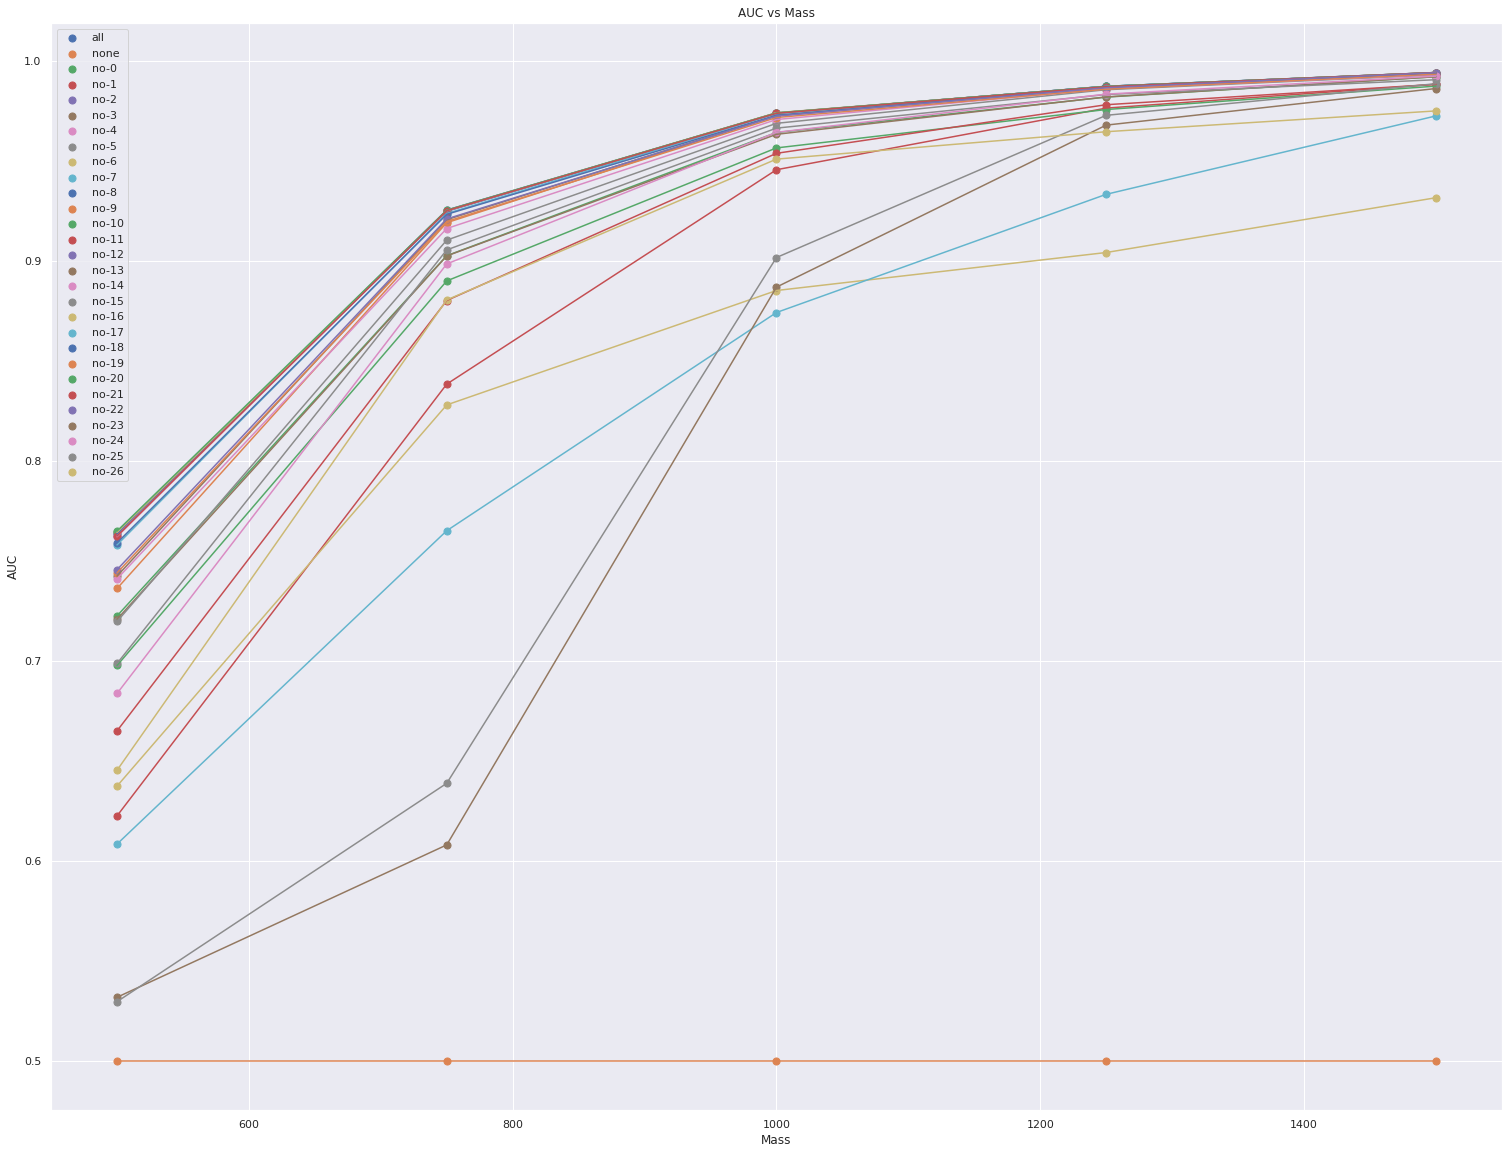

{'all': [0.7639, 0.9254, 0.9739, 0.9873, 0.9942],
 'no-0': [0.7225, 0.9026, 0.9642, 0.9819, 0.9921],
 'no-1': [0.6225, 0.8384, 0.9456, 0.9764, 0.9883],
 'no-10': [0.6977, 0.89, 0.9565, 0.9757, 0.9874],
 'no-11': [0.665, 0.8802, 0.9538, 0.9781, 0.9883],
 'no-12': [0.7643, 0.9248, 0.974, 0.9872, 0.9942],
 'no-13': [0.7424, 0.9206, 0.9727, 0.9865, 0.9938],
 'no-14': [0.741, 0.9162, 0.9707, 0.9861, 0.9932],
 'no-15': [0.6987, 0.9055, 0.9664, 0.9832, 0.9906],
 'no-16': [0.7643, 0.9251, 0.9741, 0.9872, 0.9942],
 'no-17': [0.758, 0.9237, 0.9736, 0.9872, 0.994],
 'no-18': [0.759, 0.9233, 0.9728, 0.9869, 0.9935],
 'no-19': [0.744, 0.9197, 0.9717, 0.9859, 0.9934],
 'no-2': [0.7627, 0.9252, 0.9739, 0.9873, 0.9941],
 'no-20': [0.7649, 0.9254, 0.974, 0.9873, 0.9942],
 'no-21': [0.7624, 0.9251, 0.9738, 0.9871, 0.9942],
 'no-22': [0.7456, 0.921, 0.9724, 0.9866, 0.9941],
 'no-23': [0.5318, 0.608, 0.8869, 0.9679, 0.9862],
 'no-24': [0.6837, 0.8985, 0.9643, 0.9834, 0.9924],
 'no-25': [0.5296, 0.6388, 0.

In [ ]:
# affine model
auc_vs_mass_no_features(affine_model, test_data, auc_index=2, mass=test_mass, 
                        features=features, limit=10_000, verbose=0)

Inspect the model's last hidden layer:
* Check if it's **sparse**, by averaging per mass

In [ ]:
# load Baldi's architecture but with "inspection" turned on (returns last hidden layer output)
model = get_baldi_compiled_model(inspect=True)
model.load_weights(f'{save_path}/baldi_3_mass/weights')

In [ ]:
def sparsity(model, batch) -> float:
    _, hidden = model(batch, training=False)
    count = tf.reduce_sum(tf.cast(hidden == 0.0, dtype=tf.float32))
    
    return round(float(count / np.prod(hidden.shape)), 4)

In [ ]:
# slice the test-data per mass value
mass_data = [test_data.get_by_mass(mass=m) for m in test_mass]

In [ ]:
# measure sparsity on each mass

for i, (batch, _) in enumerate(mass_data):
    mass = round(test_mass[i])
    print(f'Sparsity for mass {mass} is {round(sparsity(model, batch) * 100.0, 4)}%')

Sparsity for mass 500 is 90.64%
Sparsity for mass 750 is 87.57%
Sparsity for mass 1000 is 86.5%
Sparsity for mass 1250 is 85.96%
Sparsity for mass 1500 is 85.85%


## Explore Data
---

In [ ]:
data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load(path=Dataset.TEST_PATH)

free_mem()
x_train, y_train = data.get()

loading...
dataset loaded.


In [ ]:
bkg = data.ds[data.ds[data.columns['label']] == 0]
sig = data.ds[data.ds[data.columns['label']] == 1]

In [ ]:
def histogram(col: str, bins=None):
    plt.title(col)
    plt.hist(bkg[col], bins=bins, alpha=0.3, label='bkg', color='red')
    plt.hist(sig[col], bins=bins, alpha=0.7, label='sig', color='blue')
    plt.legend()

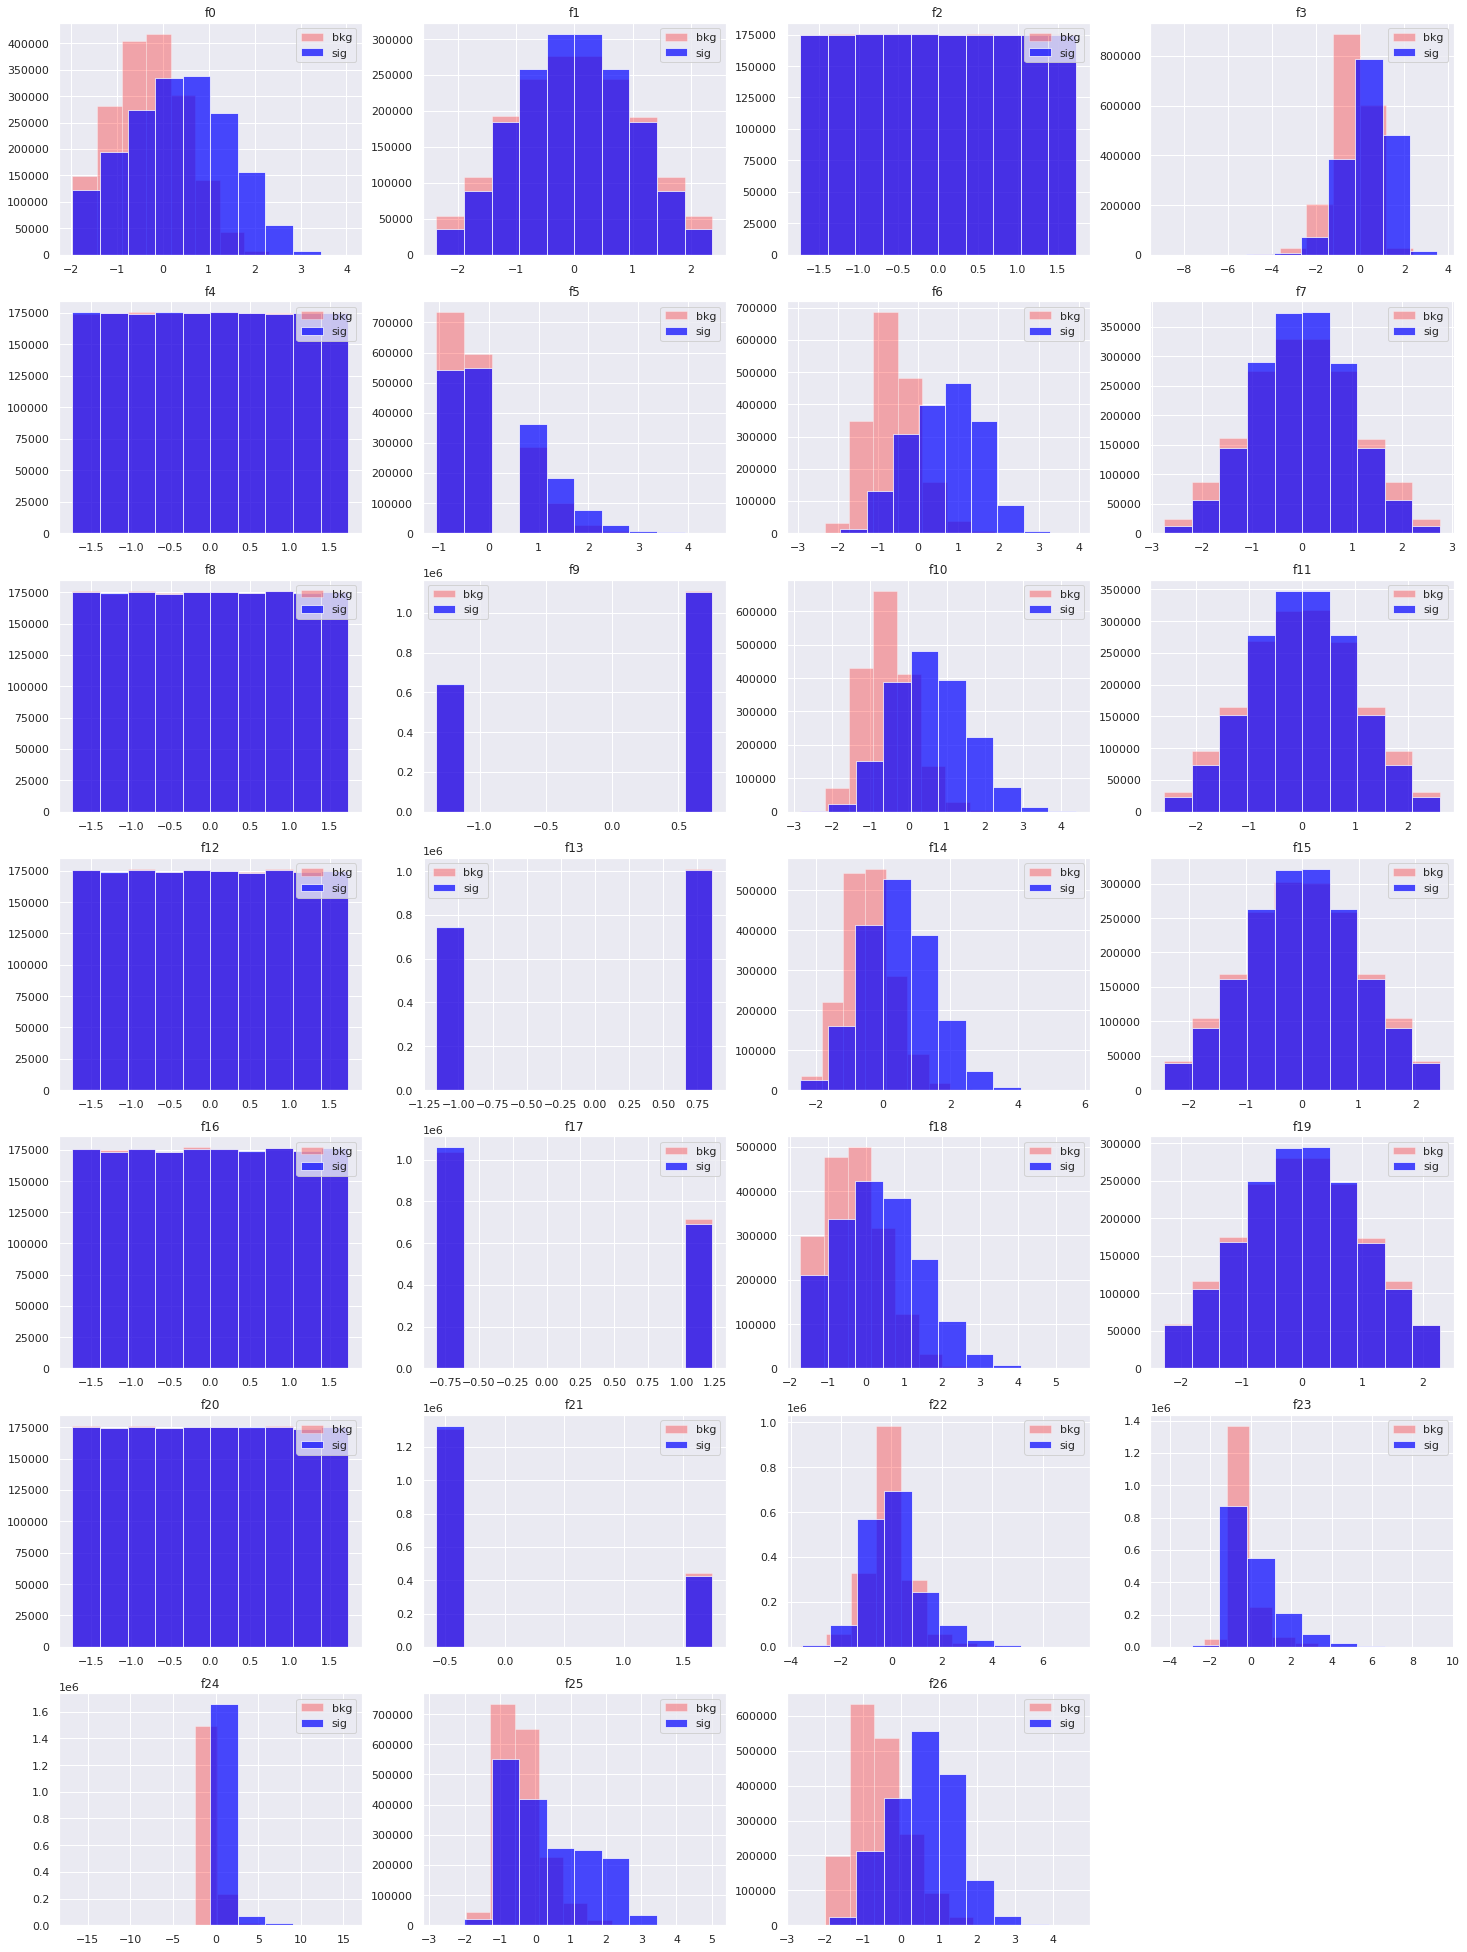

In [ ]:
# compare feature distribution
plt.figure(figsize=(25, 35))

for i, col in enumerate(data.columns['feature']):
    plt.subplot(7, 4, i + 1)
    histogram(col)

In [ ]:
def scatter(col: str, limit=10_000, seed=SEED):
    mass_bkg = bkg[data.columns['mass']].sample(limit, random_state=seed)
    col_bkg = bkg[col].sample(limit, random_state=seed)
    
    mass_sig = sig[data.columns['mass']].sample(limit, random_state=seed)
    col_sig = sig[col].sample(limit, random_state=seed)
    
    plt.title(f'mA vs {col}')
    plt.scatter(mass_sig, col_sig, alpha=0.7, label='sig', color='blue', marker='s', s=40)
    plt.scatter(mass_bkg, col_bkg, alpha=0.3, label='bkg', color='red', marker='o', s=10)
    
    plt.xlabel('mA')
    plt.ylabel(col)
    plt.legend()

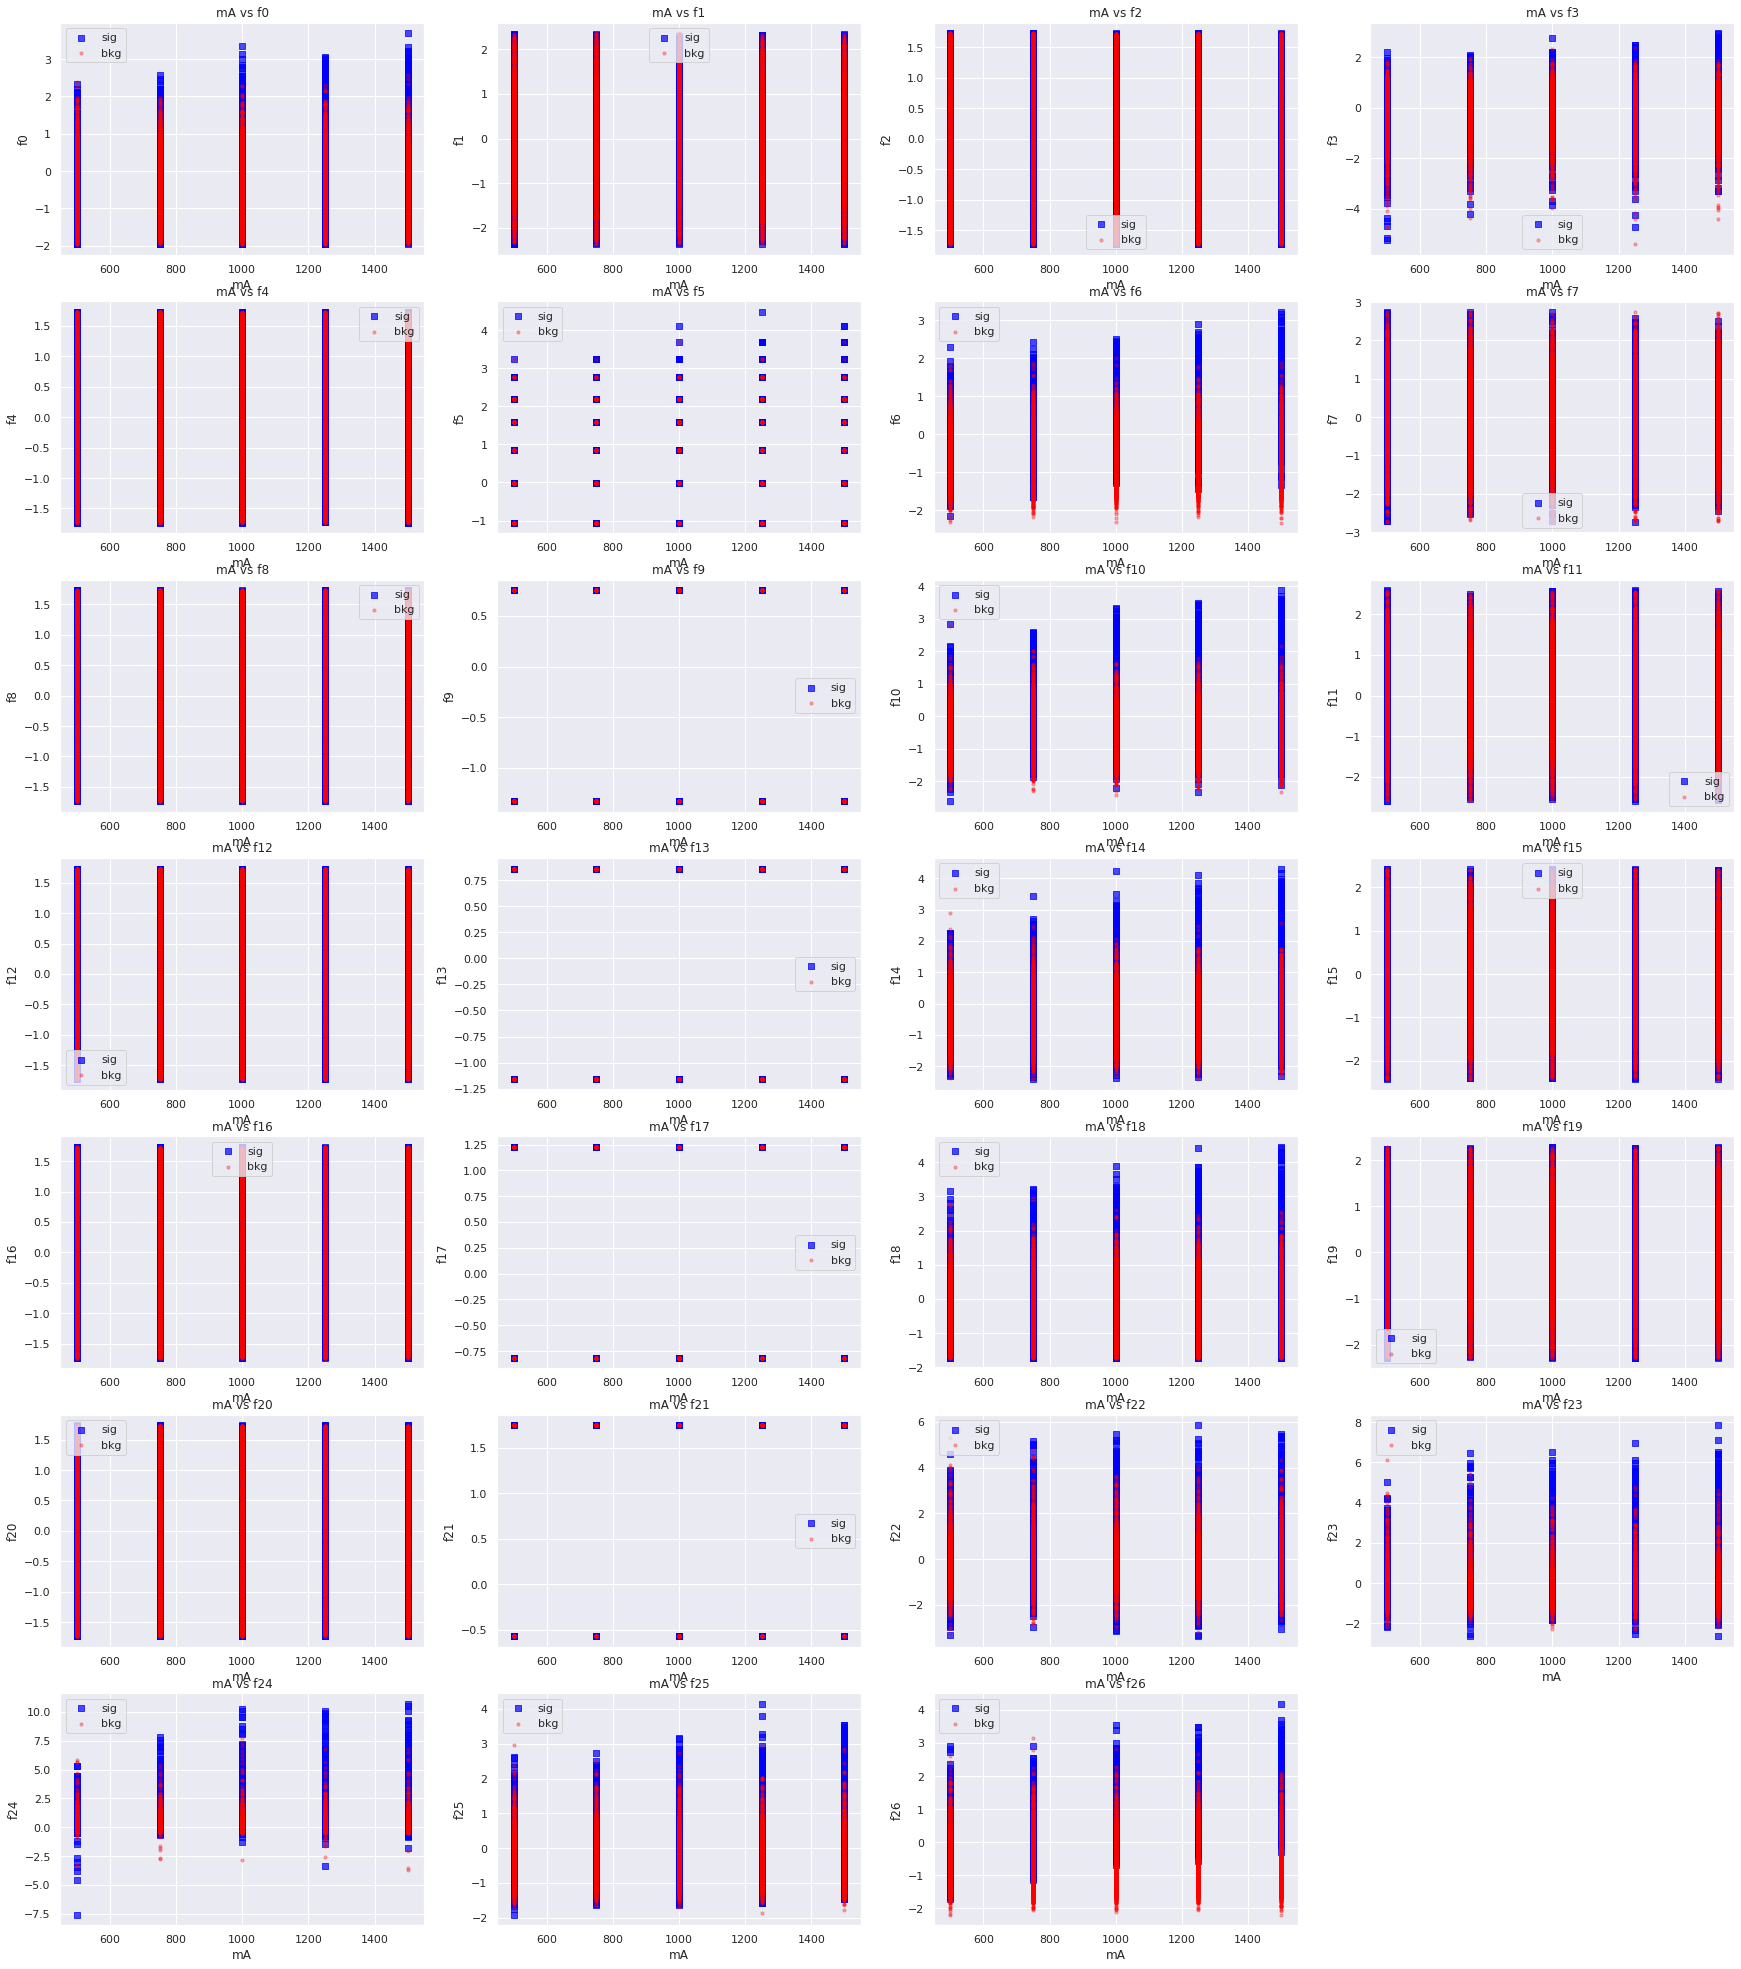

In [ ]:
plt.figure(figsize=(30, 35))

for i, col in enumerate(data.columns['feature']):
    plt.subplot(7, 4, i + 1)
    scatter(col)